<a href="https://colab.research.google.com/github/mcvlix/lorenz-96-hybrid-esn/blob/main/hybrid_rcesn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Mount your Drive ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# === Libraries ===
import sys
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from tqdm import tqdm
from tqdm import trange
import torch
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse import linalg
from pathlib import Path
import gc
import pickle

In [3]:
# === Paths ===
project_path = '/content/drive/My Drive/AM170B Project'
data_path = os.path.join(project_path, 'data')
states_path = os.path.join(project_path, 'hybrid_states')
checkpoints_path = os.path.join(project_path, 'checkpoints')
models_path = os.path.join(project_path, 'models')
predictions_path = os.path.join(project_path, 'predictions')
plots_path = os.path.join(project_path, 'plots')
os.makedirs(states_path, exist_ok=True)
os.makedirs(checkpoints_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)
os.makedirs(predictions_path, exist_ok=True)
os.makedirs(plots_path, exist_ok=True)

In [4]:
os.listdir(project_path)

['data',
 'checkpoints',
 'states',
 'models',
 'old_rcesn.ipynb',
 'predictions',
 'plots',
 'rcesn.ipynb',
 'hybrid_states',
 'hybrid_rcesn.ipynb']

In [5]:
# === View Memory Usage ===
def whos_memory(namespace):
    exclude = {
        'np', 'pd', 'plt', 'os', 'gc', 'sys', 'sio', 'tqdm', 'torch', 'sparse', 'Path',
        'exit', 'quit', 'open', 'get_ipython', 'whos_memory'
    }
    print(f"{'Variable':20} {'Type':15} {'Size (MB)':>10}")
    print("-" * 50)
    for name, val in namespace.items():
        if name.startswith("_") or name in exclude:
            continue
        try:
            size = sys.getsizeof(val) / 1024 / 1024
            print(f"{name:20} {type(val).__name__:15} {size:10.4f}")
        except Exception:
            print(f"{name:20} {type(val).__name__:15} {'<unknown>'}")

# del
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0001
Out                  dict                0.0002
drive                module              0.0001
cp                   module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001


### ESN Parameters

In [6]:
# === Parameters ===
shift_k = 0  # Start index for initial condition
approx_res_size = 5000

model_params = {
    'tau': 0.25,
    'nstep': 1000,
    'N': 16, # 8 from model, 8 from data
    'd': 22
}

res_params = {
    'radius': 0.1,
    'degree': 3,
    'sigma': 0.5,
    'train_length': 500000,
    'N': int(np.floor(approx_res_size / model_params['N']) * model_params['N']),
    'num_inputs': model_params['N'],
    'predict_length': 1000,
    'beta': 0.0001
}

### Imperfect Model

In [7]:
# === Constants ===
K = 8
J = 8
F = 20
h=.5
c = 8
b = 10
dt = 0.005
T = 500000

# === Imperfect Step Function (Z excluded) ===
def x_der(x_vec, y_mat):
    y_avg = np.sum(y_mat, 0).squeeze()
    minus = [-1, 0, 1, 2, 3, 4, 5, 6]
    minus2 = [-2, -1, 0, 1, 2, 3, 4, 5]
    plus = [1, 2, 3, 4, 5, 6, 7, 0]

    x_minus = x_vec[minus]
    x_minus2 = x_vec[minus2]
    x_plus = x_vec[plus]

    dx = x_minus * (x_plus - x_minus2) - x_vec + F - (h * c / b) * y_avg
    return dx

def y_der(x_vec, y_mat):
  minus = [-1, 0, 1, 2, 3, 4, 5, 6]
  plus = [1, 2, 3, 4, 5, 6, 7, 0]
  plus2 = [2, 3, 4, 5, 6, 7, 0, 1]

  y_minus = y_mat[minus, :]
  y_plus = y_mat[plus, :]
  y_plus2 = y_mat[plus2, :]

  dy = -c * b * y_plus * (y_plus2 - y_minus) - c * y_mat + (h * c / b) * x_vec
  return dy


def x_step(x_vec, y_mat, dt_x):
    dx1 = x_der(x_vec, y_mat)
    dy1 = y_der(x_vec, y_mat)

    x_vec2 = x_vec + .5 * dt_x * dx1
    y_mat2 = y_mat + .5 * dt_x * dy1

    dx2 = x_der(x_vec2, y_mat)
    dy2 = y_der(x_vec2, y_mat2)

    x_vec3 = x_vec + .5 * dt_x * dx2
    y_mat3 = y_mat + .5 * dt_x * dy2

    dx3 = x_der(x_vec3, y_mat)
    dy3 = y_der(x_vec3, y_mat3)

    x_vec4 = x_vec + dt_x * dx3
    y_mat4 = y_mat + dt_x * dy3

    dx4 = x_der(x_vec4, y_mat)
    dy4 = y_der(x_vec4, y_mat4)

    x_vec = x_vec + dt_x / 6 * (dx1 + 2 * dx2 + 2 * dx3 + dx4)
    y_mat = y_mat + dt_x / 6 * (dy1 + 2 * dy2 + 2 * dy3 + dy4)

    return x_vec,y_mat

def plot_imperfect_vs_truth(X_true, X_model, start=0):
    X_diff = X_true - X_model

    time_axis = np.arange(start, start + X_true.shape[1])
    space_axis = np.arange(X_true.shape[0])

    fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

    # --- Ground truth ---
    c1 = axs[0].contourf(time_axis, space_axis, X_true, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[0].set_title("True $X_k$ (from timestep {})".format(start))
    axs[0].set_ylabel("$X_k$")
    axs[0].set_yticks(space_axis)
    axs[0].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c1, ax=axs[0], ticks=[-2, 0, 2])

    # --- Imperfect Model ---
    c2 = axs[1].contourf(time_axis, space_axis, X_model, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[1].set_title("Imperfect Model $X_k$")
    axs[1].set_ylabel("$X_k$")
    axs[1].set_yticks(space_axis)
    axs[1].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c2, ax=axs[1], ticks=[-2, 0, 2])

    # --- Difference ---
    c3 = axs[2].contourf(time_axis, space_axis, X_diff, levels=50, cmap='seismic', vmin=-2.5, vmax=2.5)
    axs[2].set_title("Difference: $X_{\\text{true}} - X_{\\text{model}}$")
    axs[2].set_xlabel("Timesteps")
    axs[2].set_ylabel("$X_k$")
    axs[2].set_yticks(space_axis)
    axs[2].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c3, ax=axs[2], ticks=[-2, 0, 2])

    plt.tight_layout()
    plt.show()

In [ ]:
# === Load True Data and Initial Conditions ===
npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
data = np.load(npy_path)           # shape: (T, 72)
T = data.shape[0]                  # Use full length
print(f"Generating X_model to match {T} timesteps")

# === Allocate
X_model = np.zeros((T, K))

# === For each t in 0...(T-1), generate K[X_true[t]] and align it with X_true[t]
for t in tqdm(range(T - 1), desc="Generating aligned X_model"):
    X_now = data[t, :K] * 6.7887 + 3.5303
    Y_now = data[t, K:].reshape(J, K, order='F') * 0.3608 + 0.1262
    X_pred, _ = x_step(X_now, Y_now, dt)
    X_model[t] = X_pred

# === Save to .npz ===
save_path = os.path.join(data_path, 'X_model_full.npz')
np.savez_compressed(save_path, X_model=X_model)
print(f"Saved X_model to {save_path}")

In [9]:
X_model.shape

(15000000, 8)

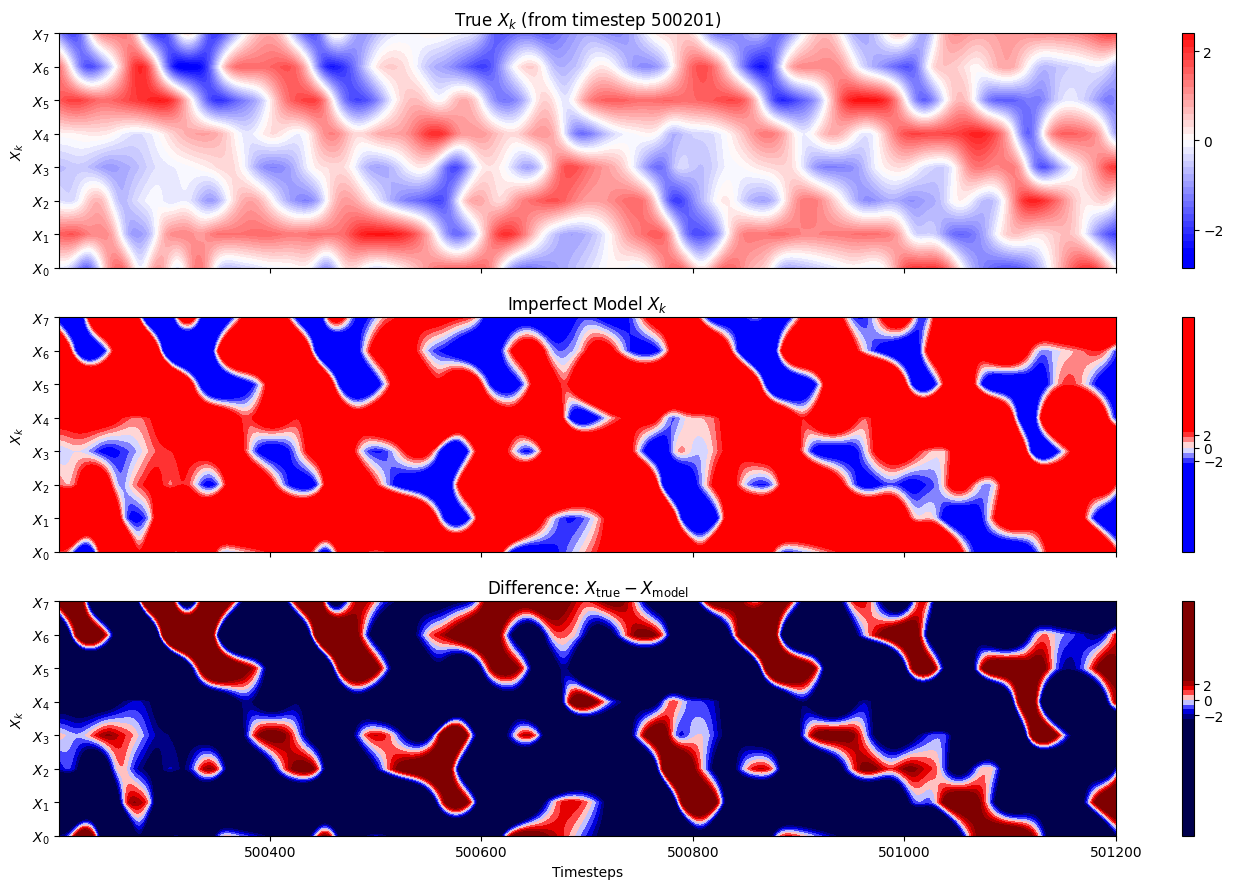

In [10]:
X_model = np.load(os.path.join(data_path, 'X_model_full.npz'))['X_model'][500201:501201].T            # shape (8, 1000)
X_true  = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'))[500201:501201, :8].T         # shape (8, 1000)
plot_imperfect_vs_truth(X_true, X_model, start=500201)

In [11]:
# === Free memory ===
del X_true, X_model, data
gc.collect()
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
drive                module              0.0001
cp                   module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict                0.0002
res_params           dict                0.0003
K                    int             

### Utilities

In [8]:
# === Utilities ===
def generate_reservoir(size, radius, degree):
    print("Generating Reservoir")
    sparsity = degree / float(size)
    A = sparse.rand(size, size, density=sparsity).todense()
    eigvals = np.linalg.eigvals(A)
    A = (A / np.max(np.abs(eigvals))) * radius
    return A

def build_input_weights(N, num_inputs, sigma):
    print("Building Input Weights")
    q = int(N / num_inputs)
    Win = np.zeros((N, num_inputs))
    for i in range(num_inputs):
        np.random.seed(i)
        Win[i * q: (i + 1) * q, i] = sigma * (-1 + 2 * np.random.rand(q))
    return Win

def reservoir_layer(A, Win, X_true, X_model, res_params, states=None):
    N = res_params['N']
    T = res_params['train_length']
    K = X_true.shape[0]

    if states is None:
        states = np.zeros((N, T))

    for t in trange(1, T, desc="Loading Hybrid Reservoir with X_true and X_model"):
        # Hybrid input u(t) = [X_model[t], X_true[t]]
        u_t = np.hstack([X_model[:, t], X_true[:, t]])
        states[:, t] = np.tanh(A @ states[:, t - 1] + Win @ u_t)

    return states

def train(res_params, r_states, X_model, X_true):
    beta = res_params['beta']
    N, T = r_states.shape
    K = X_model.shape[1]

    # === Transform r_states into r_star in-place
    for j in trange(2, N - 2, desc="Transforming r_states → r* in-place"):
        if j % 2 == 0:
            r_states[j, :] = r_states[j - 1, :] * r_states[j - 2, :]

    # === Design matrix: [X_model; r*] shape → (K + N, T)
    X = np.vstack([X_model, r_states])  # (K + N, T)
    Y = X_true                          # (K, T)

    # === Tikhonov regularization (ridge regression)
    I = beta * np.identity(K + N)        # Dense identity matrix
    U = np.dot(X, X.T) + I
    W_out = np.dot(np.linalg.inv(U), np.dot(X, Y.T))  # (K + N, K)
    # W_out = np.linalg.solve(U, X @ Y.T)

    return W_out.T  # shape: (K, K + N)


def train_gpu(res_params, r_states, X_model, X_true):
    beta = res_params['beta']
    N, T = r_states.shape
    K = X_model.shape[0]  # Assuming shape (K, T)

    # === Convert to CuPy arrays
    r_states = cp.asarray(r_states)
    X_model = cp.asarray(X_model)
    X_true = cp.asarray(X_true)

    # === Transform r_states → r* in-place
    for j in trange(2, N - 2, desc="Transforming r_states → r* in-place (GPU)"):
        if j % 2 == 0:
            r_states[j, :] = r_states[j - 1, :] * r_states[j - 2, :]

    # === Stack input features: [X_model; r*] → (K + N, T)
    X = cp.vstack([X_model, r_states])
    Y = X_true

    # === Ridge Regression
    I = beta * cp.identity(K + N)
    U = X @ X.T + I
    # W_out = cp.dot(cp.linalg.inv(U), cp.dot(X, Y.T))
    W_out = cp.linalg.solve(U, X @ Y.T)  # (K + N, K)

    return W_out.T  # shape: (K, K + N)

### Load Reservoir States

In [13]:
# === Generate Reservoir Matrices ===
A = generate_reservoir(res_params['N'], res_params['radius'], res_params['degree'])
Win = build_input_weights(res_params['N'], res_params['num_inputs'], res_params['sigma'])

Generating Reservoir
Building Input Weights


In [14]:
# === Load True Data and Imperfect Model Data (200:500200) ===
start = 200
end = 500200

# Load true state X_true[t]
X_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'))[start:end, :K].T

# Load imperfect model prediction K[X_true[t-1]]
X_model = np.load(os.path.join(data_path, 'X_model_full.npz'))['X_model'][start:end].T

In [15]:
print("X_model shape:    ", X_model.shape)      # → (K, T)
print("X_true shape:     ", X_true.shape)       # → (K, T)

X_model shape:     (8, 500000)
X_true shape:      (8, 500000)


In [16]:
# === Run reservoir layer using selected time window ===
r_states = reservoir_layer(A, Win, X_true, X_model, res_params)

Loading Hybrid Reservoir with X_true and X_model: 100%|██████████| 499999/499999 [33:03<00:00, 252.07it/s]


In [17]:
print("r_states shape:   ", r_states.shape)     # → (N, T)

r_states shape:    (4992, 500000)


In [18]:
# === Save Checkpoint (A, Win)
checkpoint_file = os.path.join(checkpoints_path, 'hybrid_checkpoint_500200.npz')
np.savez_compressed(checkpoint_file, A=A, Win=Win)

In [19]:
# === Save Reservoir States
np.savez_compressed(os.path.join(states_path, 'r_states_hybrid.npz'), r_states=r_states)

In [20]:
# === Optional: Free memory
del A, Win, X_true, X_model, r_states
gc.collect()
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
drive                module              0.0001
cp                   module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict                0.0002
res_params           dict                0.0003
K                    int             

### Train Model

In [9]:
r_states = np.load(os.path.join(states_path, 'r_states_hybrid.npz'))['r_states'][:, :500000]
X_model = np.load(os.path.join(data_path, 'X_model_full.npz'))['X_model'][200:500200].T
X_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'))[200:500200, :8].T

In [10]:
print("r_states shape:   ", r_states.shape)     # → (N, T)
print("X_model shape:    ", X_model.shape)      # → (K, T)
print("X_true shape:     ", X_true.shape)       # → (K, T)

r_states shape:    (4992, 500000)
X_model shape:     (8, 500000)
X_true shape:      (8, 500000)


In [11]:
# Train output weights
W_out = train_gpu(res_params, r_states, X_model, X_true)

Transforming r_states → r* in-place (GPU): 100%|██████████| 4988/4988 [00:01<00:00, 3104.31it/s]


In [13]:
del r_states, X_model, X_true
gc.collect()
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
drive                module              0.0001
cp                   module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict                0.0002
res_params           dict                0.0003
K                    int             

### Save States and Model

In [12]:
# Save model components
checkpoint = np.load(os.path.join(checkpoints_path, 'hybrid_checkpoint_500000.npz'))
A = checkpoint['A']
Win = checkpoint['Win']

model_file = os.path.join(models_path, 'hybrid_model.npz')
np.savez_compressed(model_file, A=A, Win=Win, W_out=W_out)

In [14]:
del A, Win, W_out
gc.collect()
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
drive                module              0.0001
cp                   module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict                0.0002
res_params           dict                0.0003
K                    int             

### Prediction

In [15]:
# Load model
model = np.load(os.path.join(models_path, 'hybrid_model.npz'))
A = model['A']
Win = model['Win']
W_out = model['W_out']

# Load initial condition from .npy file
npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
init = np.load(npy_path)[500201]
X_init = init[:K]
Y_init = init[K:].reshape(J, K)

In [16]:
def predict_hybrid(A, Win, W_out, X_init, Y_init, x_step, res_params):
    K = res_params['num_inputs'] // 2  # e.g., 8
    N = res_params['N']
    T_pred = res_params['predict_length']
    dt = 0.005

    # === Allocate
    X_preds = np.zeros((K, T_pred))
    r = np.zeros((N,))
    X = X_init.copy()
    Y = Y_init.copy()

    for t in tqdm(range(T_pred), desc="Hybrid Prediction"):
        # === Imperfect model prediction: X_model = K[X(t)]
        X_model, Y = x_step(X, Y, dt)

        # === Reservoir input: u(t) = [K[X(t)], X(t)]
        u = np.hstack([X_model, X])
        r = np.tanh(A @ r + Win @ u)

        # === Apply r* nonlinearity
        r_star = r.copy()
        for j in range(2, N - 2):
            if j % 2 == 0:
                r_star[j] = r[j - 1] * r[j - 2]

        # === Predict next state X(t+1)
        hybrid_input = np.hstack([X_model, r_star])
        X = W_out @ hybrid_input

        # === Store prediction
        X_preds[:, t] = X

    # === Debug Shapes ===
    print("\n=== Shape Debug Info ===")
    print("X_model shape      :", X_model.shape)
    print("X_init shape       :", X_init.shape)
    print("Final X shape      :", X.shape)
    print("Final r shape      :", r.shape)
    print("Final u shape      :", u.shape)
    print("Final hybrid_input :", hybrid_input.shape)
    print("X_preds shape      :", X_preds.shape)
    print("W_out shape        :", W_out.shape)
    print("==========================")

    return X_preds

In [17]:
# === Run prediction ===
X_preds = predict_hybrid(
    A=A,
    Win=Win,
    W_out=W_out,
    X_init=X_init,
    Y_init=Y_init,
    x_step=x_step,  # should point to your stable RK4 implementation
    res_params=res_params
)

# === Save prediction ===
pred_path = os.path.join(predictions_path, 'X_preds_hybrid_500201.npz')
np.savez_compressed(pred_path, X_preds=X_preds)
print(f"Saved prediction to {pred_path}")

Hybrid Prediction: 100%|██████████| 1000/1000 [00:07<00:00, 133.30it/s]



=== Shape Debug Info ===
X_model shape      : (8,)
X_init shape       : (8,)
Final X shape      : (8,)
Final r shape      : (4992,)
Final u shape      : (16,)
Final hybrid_input : (5000,)
X_preds shape      : (8, 1000)
W_out shape        : (8, 5000)
Saved prediction to /content/drive/My Drive/AM170B Project/predictions/X_preds_hybrid_500201.npz


In [18]:
del A, Win, W_out, X_init, Y_init, X_preds
gc.collect()
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
drive                module              0.0001
cp                   module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict                0.0002
res_params           dict                0.0003
K                    int             

### Plot Predictions

In [19]:
# === Plotting function ===
def plot_hybrid_prediction(X_true, X_pred, start, res_params, plots_path):
    X_diff = X_true - X_pred
    time_axis = np.arange(start, start + res_params['predict_length'])
    space_axis = np.arange(res_params['num_inputs'] // 2)

    fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

    # --- True ---
    c1 = axs[0].contourf(time_axis, space_axis, X_true, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[0].set_title(f"True $X_k$ (from timestep {start})")
    axs[0].set_ylabel("$X_k$")
    axs[0].set_yticks(space_axis)
    axs[0].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c1, ax=axs[0]).set_ticks([-2, 0, 2])

    # --- Predicted ---
    c2 = axs[1].contourf(time_axis, space_axis, X_pred, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[1].set_title("Hybrid ESN Prediction")
    axs[1].set_ylabel("$X_k$")
    axs[1].set_yticks(space_axis)
    axs[1].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c2, ax=axs[1]).set_ticks([-2, 0, 2])

    # --- Difference ---
    c3 = axs[2].contourf(time_axis, space_axis, X_diff, levels=50, cmap='seismic', vmin=-2.5, vmax=2.5)
    axs[2].set_title("Difference: $X_{\\text{true}} - X_{\\text{pred}}$")
    axs[2].set_xlabel("Timesteps")
    axs[2].set_ylabel("$X_k$")
    axs[2].set_yticks(space_axis)
    axs[2].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c3, ax=axs[2]).set_ticks([-2, 0, 2])

    # === Save and show ===
    plot_filename = f'prediction_plot_start{start}_len{res_params["predict_length"]}.png'
    plt.tight_layout()
    plt.savefig(os.path.join(plots_path, plot_filename), dpi=300)
    plt.show()

In [20]:
# === Load predicted data ===
pred_path = os.path.join(predictions_path, 'X_preds_hybrid_500201.npz')
X_pred = np.load(pred_path)['X_preds']  # shape: (8, predict_length)

# === Load corresponding true data ===
truth_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
X_true = np.load(truth_path)[500201:500201 + res_params['predict_length'], :K].T  # shape: (8, predict_length)


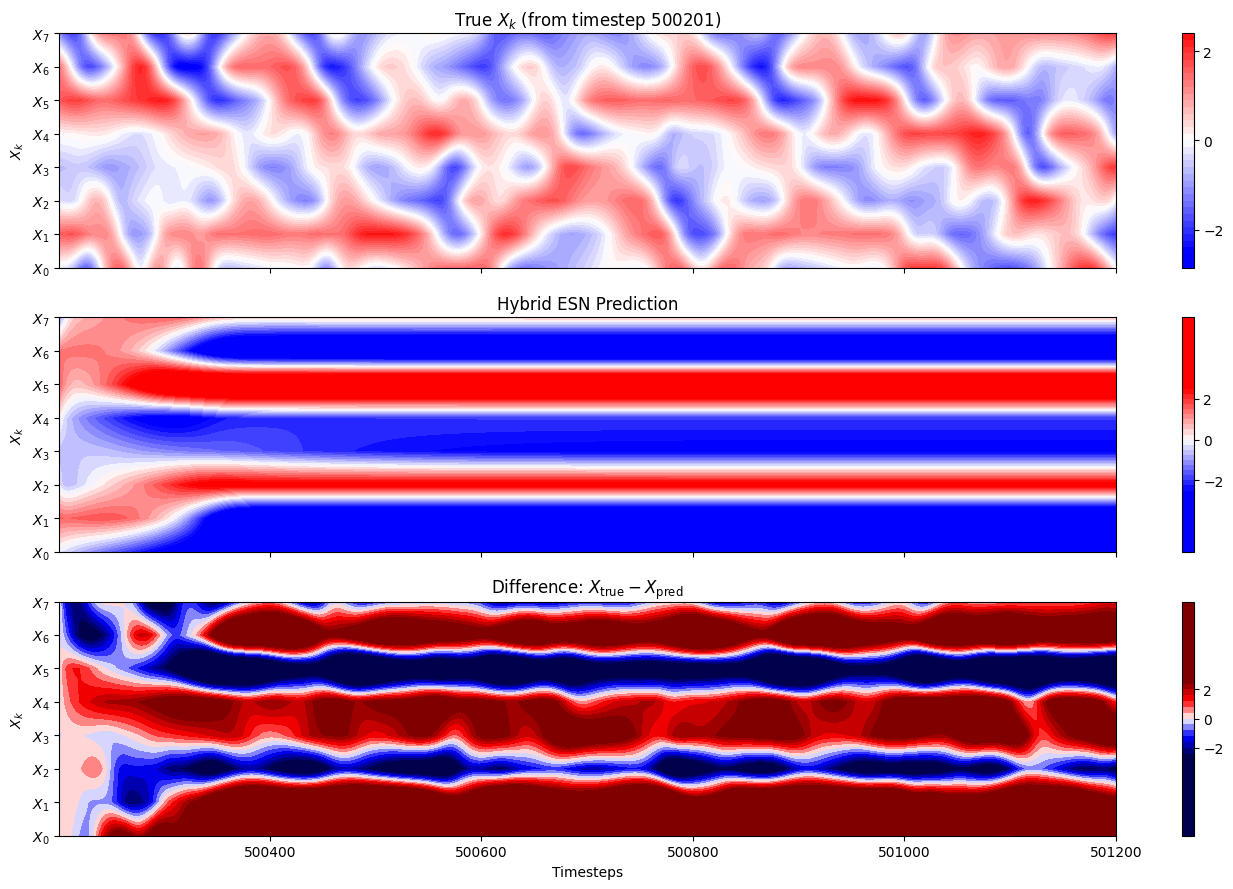

In [21]:
# === Call the plotter ===
plot_hybrid_prediction(X_true, X_pred, start=500201, res_params=res_params, plots_path=plots_path)

In [22]:
X_model = np.load(os.path.join(data_path, 'X_model_full.npz'))['X_model'].T  # shape: (8, 1500000)
X_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'))[:, :8].T  # shape: (8, 1500000)


In [23]:
t = 100

# This is the true state at t=0
print("X_true[ :, 0 ]:", X_true[:, t])

# This is the imperfect prediction made *from* X_true[:, 0]
print("X_model[ :, 0 ]:", X_model[:, t])

X_true[ :, 0 ]: [ 1.41426259 -0.06409119 -1.13304633 -0.11999852  0.77286602  0.68414888
  0.22457434  0.73496523]
X_model[ :, 0 ]: [13.06097952  2.34177615 -4.17971249  2.6734258   8.99798068  8.33664751
  5.11620103  8.69631114]


In [24]:
print(X_model.shape)
print(X_true.shape)

(8, 15000000)
(8, 15000000)


In [25]:
for t in [0, 1, 2, 10, 100, 999]:
    print(f"\nTime Step {t}")
    print("X_true :", X_true[:, t])
    print("X_model:", X_model[:, t])


Time Step 0
X_true : [-0.47706096 -0.05103646 -0.46687787 -0.19116323 -0.04937958 -0.33290759
 -0.33640259 -1.03165354]
X_model: [ 0.35207551  3.26909637  0.48924615  2.32061724  3.29059298  1.35244576
  1.29440044 -3.35474275]

Time Step 1
X_true : [-0.46925669 -0.03994395 -0.44865133 -0.17867634 -0.0359692  -0.32136196
 -0.32898176 -1.01502691]
X_model: [ 0.40515666  3.33885885  0.6150665   2.40715912  3.38354721  1.43302678
  1.34191015 -3.24329882]

Time Step 2
X_true : [-0.46108032 -0.02906683 -0.43004445 -0.16613134 -0.0224201  -0.30978303
 -0.32196692 -0.99865201]
X_model: [ 0.46652014  3.41410841  0.74537048  2.49202242  3.47643713  1.51085357
  1.38730442 -3.13460815]

Time Step 10
X_true : [-0.39049662  0.07089979 -0.27414451 -0.06367055  0.08289041 -0.22550043
 -0.2765187  -0.87451764]
X_model: [ 0.95041525  4.10273221  1.81041895  3.1926596   4.18146418  2.06647787
  1.68127122 -2.30057124]

Time Step 100
X_true : [ 1.41426259 -0.06409119 -1.13304633 -0.11999852  0.7728660